In [35]:
#%% GENERAL SETTING & STATEMENTS
import pandas as pd
import numpy as np
import os
import ctypes     
import math
import matplotlib.pyplot as plt

ODYM_path = './ODYM'

import sys 
sys.path.append(ODYM_path)
import dynamic_stock_model
from dynamic_stock_model import DynamicStockModel as DSM


In [36]:
# define a function for calculating the histrocial cement stock from production data
def from_inflow_to_stock(dis_type,shape_stddev, scale_mean, inflow, strat_year,num_year, num_prov):            # length is the number of years in the entire period
    out_sc = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns =  pd.MultiIndex.from_product([list(range(1,num_prov+1)), list(range(strat_year,strat_year+num_year))]))  # Multi-index columns (region & years), to contain a matrix of years*years for each region
    out_oc = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns =  pd.MultiIndex.from_product([list(range(1,num_prov+1)), list(range(strat_year,strat_year+num_year))]))  # Multi-index columns (region & years), to contain a matrix of years*years for each region
    out_s = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns = range(1,num_prov+1))
    idx = pd.IndexSlice

    for prov in range(1,num_prov+1):
        #shape_list = shape.loc[prov]
        #scale_list = scale.loc[prov]
        inflow_prov = inflow.iloc[prov-1].values
        if dis_type == 'Weibull':  
            shape_list = np.full(num_year, shape_stddev) # can be changed to a list of shape values
            scale_list = np.full(num_year, scale_mean) # can be changed to a list of shape values
            DSMforward = DSM(t = np.arange(0,num_year,1), i =  np.array(inflow_prov), lt = {'Type': 'Weibull', 'Shape': np.array(shape_list), 'Scale': np.array(scale_list)})
        elif dis_type == 'Normal':
            stddev_list = np.full(num_year, shape_stddev) # can be changed to a list of shape values
            mean_list = np.full(num_year, scale_mean) # can be changed to a list of shape values
            DSMforward = DSM(t = np.arange(0,num_year,1), i =  np.array(inflow_prov), lt = {'Type': 'Normal', 'Mean': np.array(mean_list), 'StdDev': np.array(stddev_list)}) # shape & scale list are actually Mean & StDev here

        out_sc_prov = DSMforward.compute_s_c_inflow_driven()

        DSMoutflow = DSM(t = np.arange(0,num_year,1), s = np.array(out_sc_prov))
        out_oc_prov = DSMoutflow.compute_o_c_from_s_c()
        
        out_sc.loc[:,idx[prov,:]]  = out_sc_prov
        out_oc.loc[:,idx[prov,:]]  = out_oc_prov

        out_s[prov] = out_sc_prov.sum(axis = 1) #Stock 
        
    
    return out_sc, out_oc, out_s

## From Historical Production to Historical Cement Stock

In [37]:
# read the historical cement production data from a specific sheet from an excel file
hist_cement_production = pd.read_excel('./data/hist_cement_production/hist_cement_production.xlsx', sheet_name = 'cement_extended', index_col = 1,usecols="A:AQ", nrows=31)
province_code = pd.read_excel('./data/hist_cement_production/hist_cement_production.xlsx', sheet_name = 'cement_extended', index_col = 1,usecols="A:B", nrows=31)
#drop the first column
hist_cement_production = hist_cement_production.drop('Province', axis = 1)
#replace all value in 'nan' with 0 
hist_cement_production = hist_cement_production.fillna(0)
#calculate the stock by cohort, outflow by cohort, and stock.
out_sc,out_oc, out_s = from_inflow_to_stock('Weibull',1.5, 25, hist_cement_production, 1982,39, 31)
# out_sc_n,out_oc_n,out_s_n = from_inflow_to_stock('Normal',7.5, 25, hist_cement_production, 1982,39, 31)

/Users/jerrysong/anaconda3/envs/temoa_py373/lib/python3.7/site-packages/pandas/io/excel/_base.py:1292: FutureWarning: Defining usecols with out of bounds indices is deprecated and will raise a ParserError in a future version.
  **kwds,


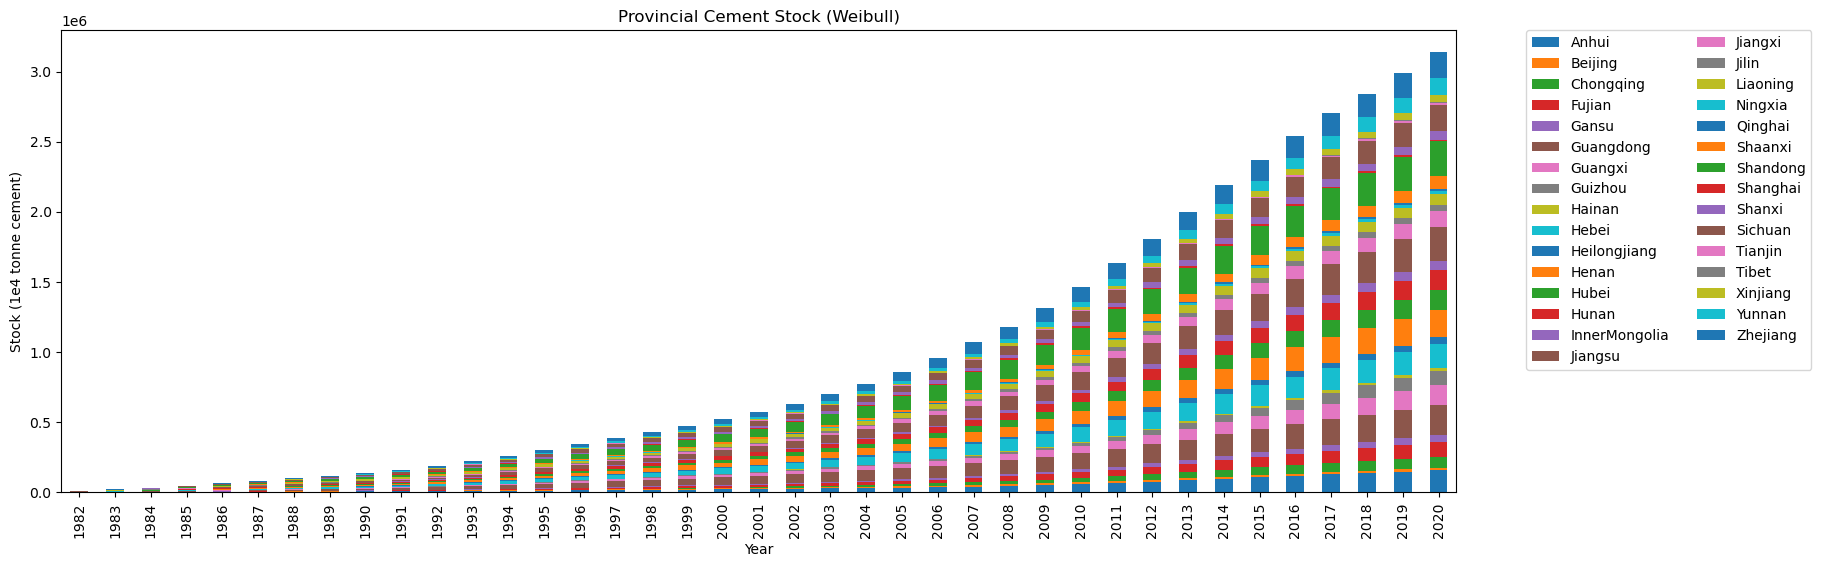

In [38]:
# plot the stock (out_s), which should be a line chart that add up all the stock in each province to national level. And color out each province.

def plot_database(df,df_title,df_ylabel):
    fig, ax = plt.subplots(figsize=(18, 6))
    df.plot(kind='bar', stacked=True, ax=ax)
    ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),ncol=2,borderaxespad = 0.)  
    ax.set_title(df_title)
    ax.set_xlabel('Year')
    ax.set_ylabel(df_ylabel)
    plt.show()
# rename the column names based on the province code
out_s_pre = out_s.copy()
out_s_pre.columns = province_code['Province']
plot_database(out_s_pre, 'Provincial Cement Stock (Weibull)','Stock (1e4 tonne cement)')
# plot_database(out_s_n, 'Provincial Cement Stock (Normal)','Stock (1e4 tonne cement)')


## Predict provincial cement stock per cap

In [39]:
pop = pd.read_excel('./data/pop/pop.xlsx', index_col = 0,usecols="A:AF", nrows=86, header=1)
# drop the first row, which have no label
pop.drop(pop.index[0], inplace=True)
# index is the year, I want to select the year from 1982 to 2020
pop_cut = pop.loc[1982:2020]
def per_capita_stock(out_s, pop_cut):
    out_s = out_s.apply(pd.to_numeric)
    pop_cut = pop_cut.apply(pd.to_numeric)
    per_cap_history = out_s / pop_cut
    return per_cap_history

per_cap_history = per_capita_stock(out_s, pop_cut)
# per_cap_history_n = per_capita_stock(out_s_n, pop_cut) 

# Calculate the national per capita stock
out_s_national = out_s.sum(axis=1)
per_cap_national = pd.DataFrame(out_s_national, columns=['National Stock'])
pop_national = pop_cut.sum(axis=1)
per_cap_national['National Population'] = pop_national
per_cap_national['Nationa PCS'] = per_cap_national['National Stock'] / per_cap_national['National Population']


In [40]:
# Adjust Jingjinji region's PCS
PCS_Jingjinji = pd.DataFrame(out_s[[2, 10, 27]].sum(axis=1), columns=['Jingjinji Stock'])
PCS_Jingjinji['Jingjinji Population'] = pop_cut[[2, 10, 27]].sum(axis=1)
PCS_Jingjinji['Jingjinji PCS'] = PCS_Jingjinji['Jingjinji Stock'] / PCS_Jingjinji['Jingjinji Population']

# PCS_Jingjinji['BJ-HB Stock'] = out_s[[2, 10]].sum(axis=1)
# PCS_Jingjinji['BJ-HB Population'] = pop_cut[[2, 10]].sum(axis=1)
# PCS_Jingjinji['BJ-HB PCS'] = PCS_Jingjinji['BJ-HB Stock'] / PCS_Jingjinji['BJ-HB Population']

# PCS_Jingjinji['TJ-HB Stock'] = out_s[[27, 10]].sum(axis=1)
# PCS_Jingjinji['TJ-HB Population'] = pop_cut[[27, 10]].sum(axis=1)
# PCS_Jingjinji['TJ-HB PCS'] = PCS_Jingjinji['TJ-HB Stock'] / PCS_Jingjinji['TJ-HB Population']

PCS_Jingjinji['Beijing PCS'] = per_cap_history[2] 
PCS_Jingjinji['Tianjin PCS'] = per_cap_history[27] 
PCS_Jingjinji['coefficient_BJ'] = PCS_Jingjinji['Beijing PCS'] / PCS_Jingjinji['Jingjinji PCS']
PCS_Jingjinji['coefficient_TJ'] = PCS_Jingjinji['Tianjin PCS'] / PCS_Jingjinji['Jingjinji PCS']

per_cap_history ['BJ_Consumption'] = PCS_Jingjinji['Jingjinji PCS']
per_cap_history ['TJ_Consumption'] = PCS_Jingjinji['Jingjinji PCS']

# Adjust Jiangzhehu region's PCS
PCS_Jiangzhehu = pd.DataFrame(out_s[[16, 24, 31]].sum(axis=1), columns=['Jiangzhehu Stock'])
PCS_Jiangzhehu['Jiangzhehu Population'] = pop_cut[[16, 24, 31]].sum(axis=1)
PCS_Jiangzhehu['Jiangzhehu PCS'] = PCS_Jiangzhehu['Jiangzhehu Stock'] / PCS_Jiangzhehu['Jiangzhehu Population']


PCS_Jiangzhehu['Shanghai PCS'] = per_cap_history[24]
PCS_Jiangzhehu['coefficient_SH'] = PCS_Jiangzhehu['Shanghai PCS'] / PCS_Jiangzhehu['Jiangzhehu PCS']

per_cap_history ['SH_Consumption'] = PCS_Jiangzhehu['Jiangzhehu PCS']

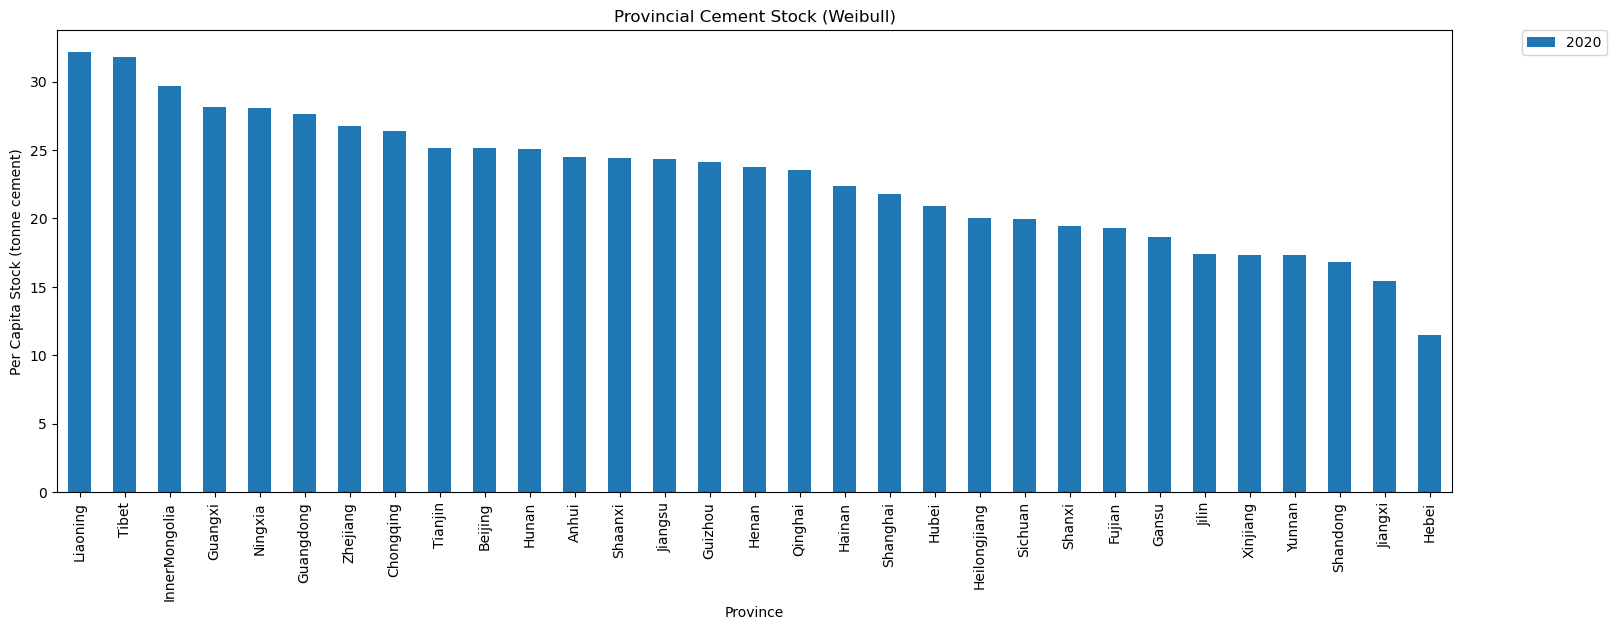

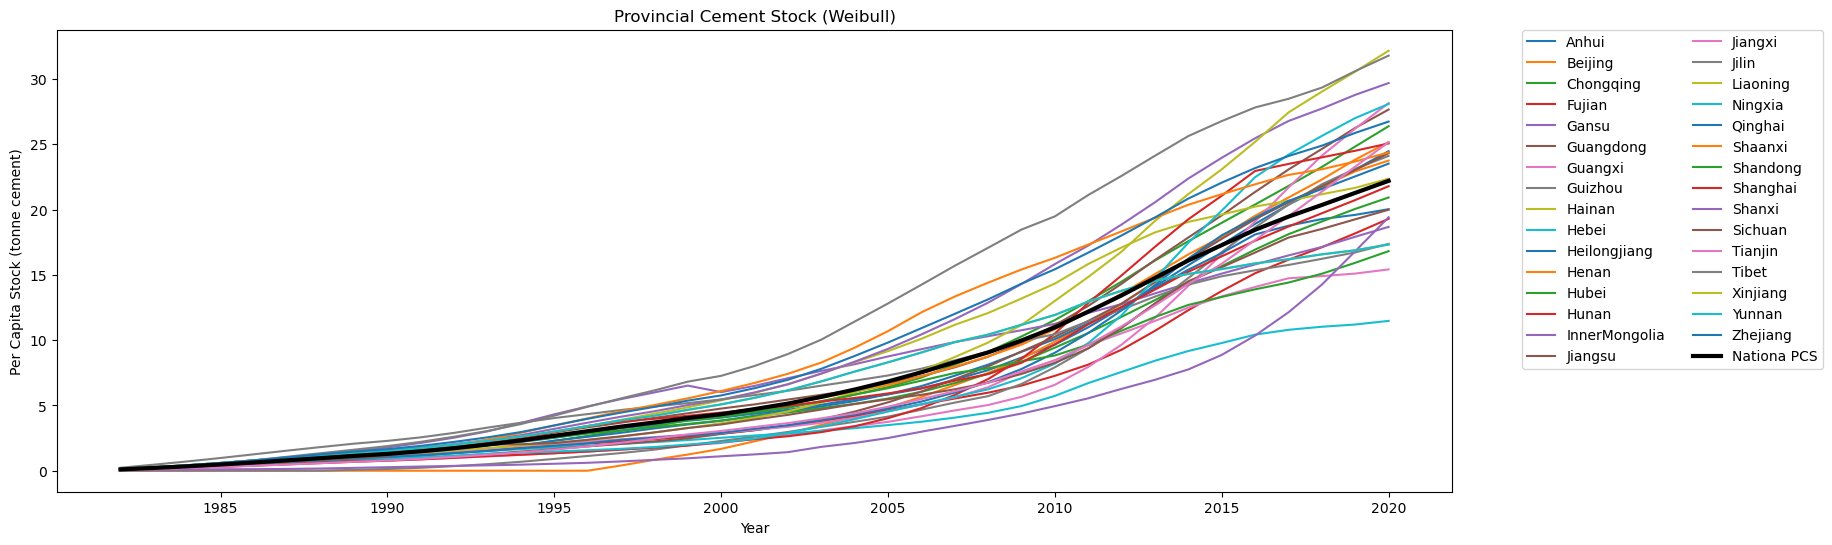

In [41]:

# draw the per capita cement stock in 2020 for each province; make the letters in the label of x-axis is horizontal
def draw_per_capita_stock(per_cap_history):
    fig, ax = plt.subplots(figsize=(18, 6))
    sorted_history = per_cap_history.loc[2020].sort_values(ascending=False)
    sorted_history.plot(kind='bar', ax=ax)
    ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),ncol=2,borderaxespad = 0.)  
    ax.set_title('Provincial Cement Stock (Weibull)')
    ax.set_xlabel('Province')
    ax.set_ylabel('Per Capita Stock (tonne cement)')
    plt.xticks(rotation=90)
    plt.show()

def rename_province_code(per_cap_history):
    per_cap_history_pre = per_cap_history.copy()
    per_cap_history_pre.columns = province_code['Province']
    return per_cap_history_pre

# draw the national per capita cement stock and provincial per capita cement stock during time periods; (set the legend outside the plot) In addition, add the per_cap_national['Per Capita Stock'] as a hightlight line.
def draw_per_capita_stock_time(per_cap_history):
    fig, ax = plt.subplots(figsize=(18, 6))
    per_cap_history.plot(ax=ax)
    per_cap_national['Nationa PCS'].plot(ax=ax, color='black', linewidth=3)
    ax.legend(loc=2, bbox_to_anchor=(1.05,1.0),ncol=2,borderaxespad = 0.)  
    ax.set_title('Provincial Cement Stock (Weibull)')
    ax.set_xlabel('Year')
    ax.set_ylabel('Per Capita Stock (tonne cement)')
    plt.show()

per_cap_history.drop(columns=[2,24,27], inplace=True)
per_cap_history.rename(columns={'BJ_Consumption': 2}, inplace=True)
per_cap_history.rename(columns={'TJ_Consumption': 24}, inplace=True)
per_cap_history.rename(columns={'SH_Consumption': 27}, inplace=True)

per_cap_history_pre = rename_province_code(per_cap_history)
draw_per_capita_stock(per_cap_history_pre)
draw_per_capita_stock_time(per_cap_history_pre)

<img src="./Requirments/system_digram/per_cap_function.png" width="790" height="470" alt="per cap function">

/Users/jerrysong/anaconda3/envs/temoa_py373/lib/python3.7/site-packages/ipykernel_launcher.py:17: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  app.launch_new_instance()


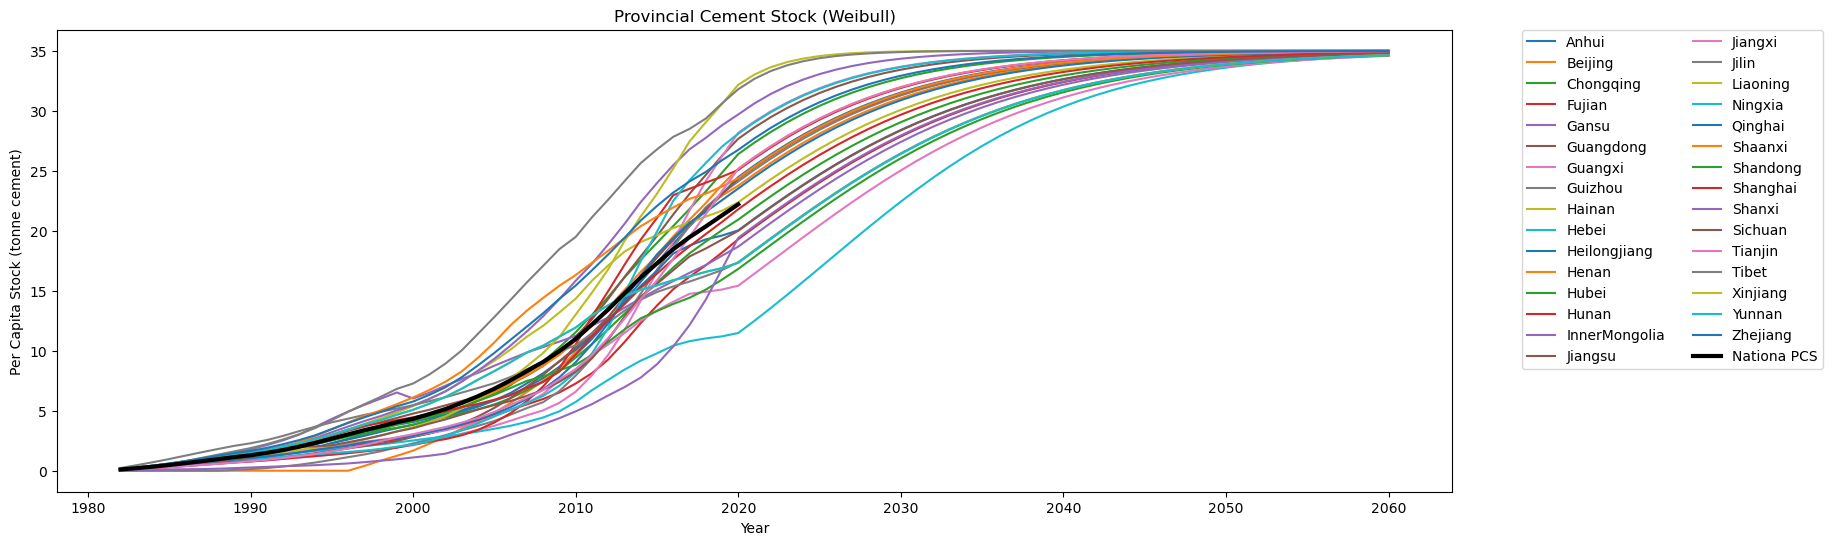

In [42]:
#c_0 =          # per-cap cement stock in 2020;
#d_0 =          # per-cap cement stock changed from 2019 to 2020;
#t_0            # the begining year of prediction (2020);
#s_level =      # the saturation level of per-cap cement stock provincial level;
def per_cap_prediction(c_0,d_0,t_0,s_level,t_f):
    d_0_1 = d_0
    d_0_2 = (s_level-c_0)/(2060-2020)
    d_0 = d_0_1*0.6 + d_0_2*0.4
    s_p = (s_level)/(1+((s_level/c_0)-1)*math.exp((-(s_level)/(c_0*(s_level-c_0)))*(t_f-t_0)))
    return s_p

def predict_PCS(num_prov,per_cap_history,s_level):
    predicted_PCS = per_cap_history.copy()
    for prov in range(1, num_prov+1):
        for year in range(2021, 2061):
            if year not in predicted_PCS.index:
                predicted_PCS.loc[year] = pd.Series(index=predicted_PCS.columns)
            predicted_PCS.loc[year][prov] = per_cap_prediction(predicted_PCS.loc[2020][prov], predicted_PCS.loc[2020][prov]-predicted_PCS.loc[2019][prov], 2020, s_level.loc[prov], year)
    return predicted_PCS

s_level = pd.DataFrame({'Value': 35}, index=range(1, 32))
predicted_PCS = predict_PCS(31,per_cap_history,s_level)

predicted_PCS_pre = rename_province_code(predicted_PCS)
draw_per_capita_stock_time(predicted_PCS_pre)

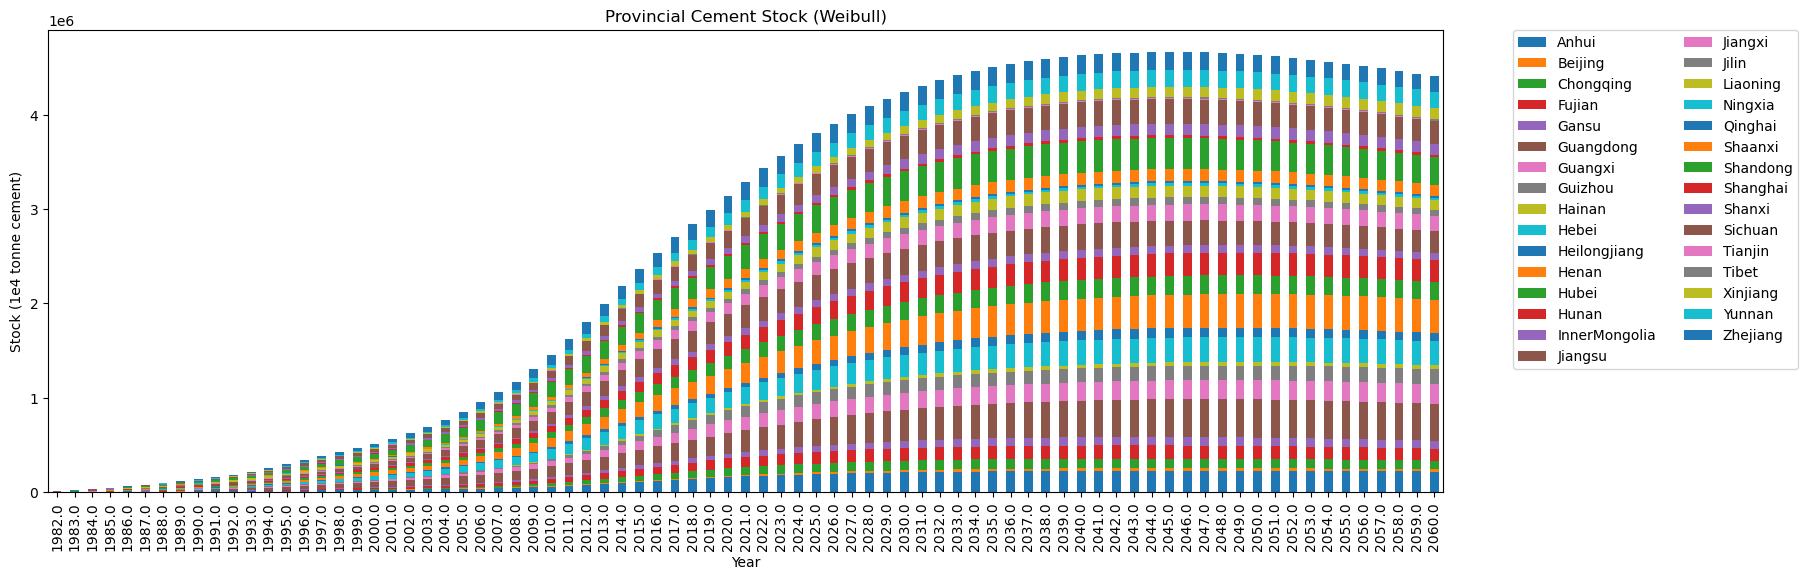

In [43]:

def total_capita_stock(predicted_PCS, pop_cut_long):
    predicted_PCS = predicted_PCS.apply(pd.to_numeric)
    # align the index of predicted_PCS
    predicted_PCS = predicted_PCS.reindex(pop_cut_long.index)
    pop_cut_long = pop_cut_long.apply(pd.to_numeric)
    stock_predicted = predicted_PCS * pop_cut_long
    return stock_predicted

pop_cut_long = pop.loc[1982:2060]
predicted_PCS[2] = predicted_PCS[2] * PCS_Jingjinji.loc[2020, 'coefficient_BJ']
predicted_PCS[24] = predicted_PCS[24] * PCS_Jingjinji.loc[2020, 'coefficient_TJ']
predicted_PCS[27] = predicted_PCS[27] * PCS_Jiangzhehu.loc[2020, 'coefficient_SH']
total_stock = total_capita_stock(predicted_PCS, pop_cut_long)

total_stock_pre = total_stock.copy()
total_stock_pre.columns = province_code['Province']
plot_database(total_stock_pre, 'Provincial Cement Stock (Weibull)','Stock (1e4 tonne cement)')

## From Predicted Stock to Predicted inflow

In [45]:
# define a function for calculating cement production from predicted cement stock
def from_stock_to_inflow_outflow(dis_type, shape_stddev, scale_mean, strat_year, num_year, num_prov, stock):            # length is the number of years in the entire period
    out_oc_reg = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns =  pd.MultiIndex.from_product([list(range(1,num_prov+1)), list(range(strat_year,strat_year+num_year))]))  # Multi-index columns (region & years), to contain a matrix of years*years for each region
    out_i_reg = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns = range(1,num_prov+1))
    out_s_reg = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns = range(1,num_prov+1))
    out_o_reg = pd.DataFrame(index = range(strat_year,strat_year+num_year), columns = range(1,num_prov+1))
    idx = pd.IndexSlice
    
    for prov in range(1,num_prov+1):

        stock_prov = stock.iloc[prov-1].values
        if dis_type == 'Weibull':  
            shape_list = np.full(num_year, shape_stddev) # can be changed to a list of shape values
            scale_list = np.full(num_year, scale_mean) # can be changed to a list of shape values
            DSMforward = DSM(t = np.arange(0,num_year,1), s =  np.array(stock_prov), lt = {'Type': 'Weibull', 'Shape': np.array(shape_list), 'Scale': np.array(scale_list)})
        elif dis_type == 'Normal':
            stddev_list = np.full(num_year, shape_stddev) # can be changed to a list of shape values
            mean_list = np.full(num_year, scale_mean) # can be changed to a list of shape values
            DSMforward = DSM(t = np.arange(0,num_year,1), s =  np.array(stock_prov), lt = {'Type': 'Normal', 'Mean': np.array(mean_list), 'StdDev': np.array(stddev_list)}) # shape & scale list are actually Mean & StDev here

        
        out_sc, out_oc, out_i = DSMforward.compute_stock_driven_model(NegativeInflowCorrect = True)
        
        out_i_reg[prov] = out_i        
        out_oc[out_oc < 0] = 0 # remove negative outflow, replace by 0
        out_oc_reg.loc[:,idx[prov,:]]  = out_oc
        
        # If you are only interested in the total outflow, you can sum the outflow by cohort
        out_o_reg[prov] = out_oc.sum(axis = 1)
        out_o_reg_corr = out_o_reg._get_numeric_data()        
        out_o_reg_corr[out_o_reg_corr < 0] = 0            
        out_s_reg[prov] = out_sc.sum(axis = 1) #Stock 
        
    return out_i_reg, out_oc_reg

In [46]:
def trans_df(df):
    pivoted = pd.DataFrame(index=df.columns, columns=df.index)
    for year in df.columns:
        for prov in df.index:
            pivoted.loc[year, prov] = df.loc[prov, year]
    return pivoted

total_stock_pivoted = trans_df(total_stock)

out_i_reg, out_oc_reg = from_stock_to_inflow_outflow('Weibull',1.5, 25, 1982, 79, 31, total_stock_pivoted)

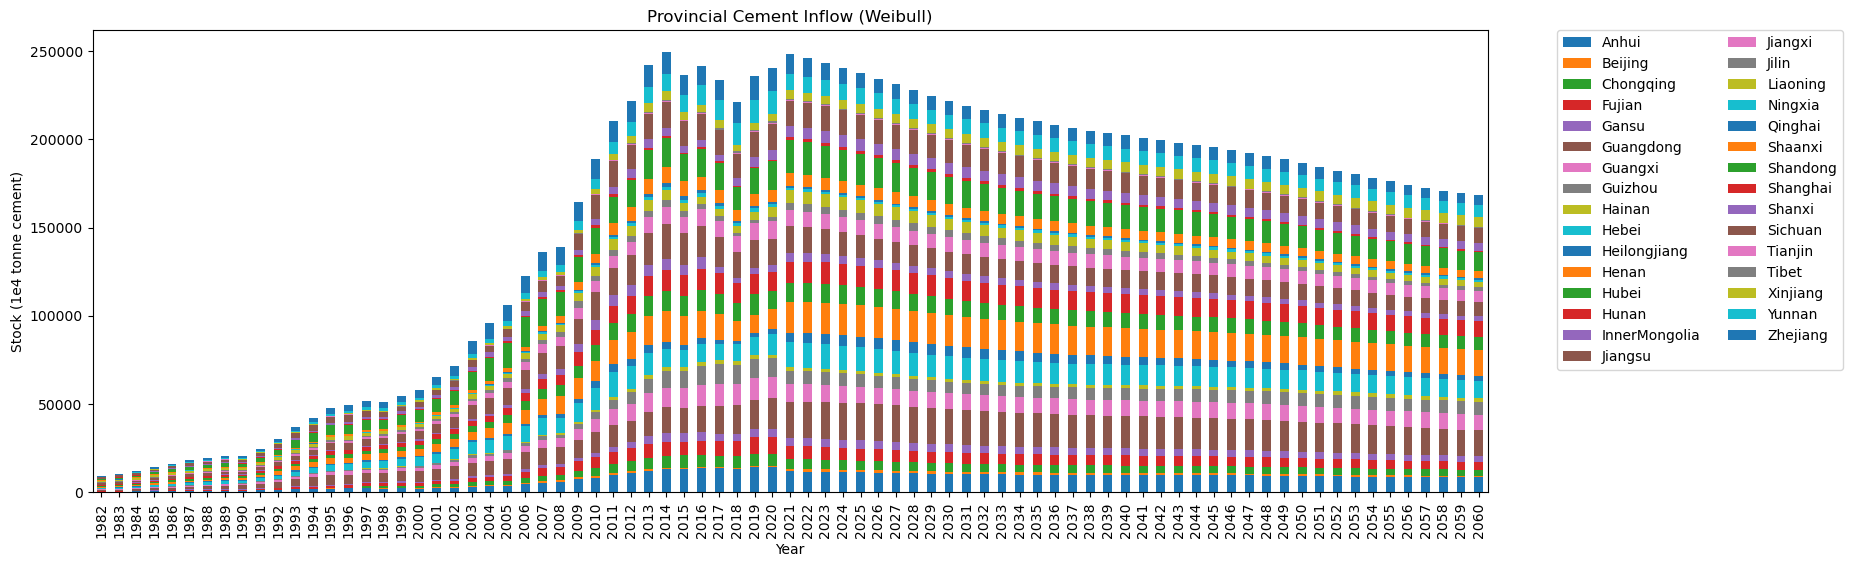

In [47]:
out_i_reg_pre = out_i_reg.copy()
out_i_reg_pre.columns = province_code['Province']
plot_database(out_i_reg_pre, 'Provincial Cement Inflow (Weibull)','Stock (1e4 tonne cement)')